# Machine Learning and Artificial Intelligence
## Stefano Brilli s249914 - homework 1

## 1 Analysis definition
In this homework, I will use the tecnique called Principal Components Analysis (PCA) to reduce the dimensionality of the dataset provided. In particular, we want to study how PCA works on images compression.

### 1.1 PCA briefly explanation
Principal Components Analysis (PCA) is a tecnique that allows us to summarize a large data set with a smaller number of representative variables that collectively explain most of the variability of out original set.
It is useful when we have a large data set, in which each observation has many features (or properties). In this scenario, it is difficult to represent data onto just 2 dimensional space and so it’s difficult to observe how data are correlated among them.
The tecnique uses the eigenvectors and eigenvalues of the correlation matrix related to our set to reproject the observations in a new lower dimensional space. The aim of this method is to reduce the dimensionality by keeping as more information as possible.

### 1.2 Tools used
The programming language used is Python (version 3.7).
The main libraries used to perform these analysis are NumPy for using arrays (http://www.numpy.org/), Sklearn for using machine learning tecniques (http://scikit-learn.org/stable/documentation.html), MatPlotLib for plotting images (https://matplotlib.org/) and Pillow to handle images (PIL, https://pillow.readthedocs.io/en/3.1.x/index.html). So, the first thing to do is to import the above libraries in order to use them.

In [12]:
from PIL import Image
import numpy as np
import os
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.colors as colo
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
import copy

### 1.3 Data preparation
The dataset contains 1087 samples with 3x227x227 sample size. The goal is to build a matrix NxM, where each row represents an image and each columns represent a feature. Since each image has three dimensions, I have to flat them to obtain a vector representing the pixels and it can be done by using the method ravel() of numpy library. The following function loads in memory the images.

In [2]:
# This method opens each class folder and gets raw pixels of each image
def getData(directory_name, x, label, y):
    directory = os.fsencode(directory_name)
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        i = Image.open(directory_name + filename)
        x.extend(np.asarray(i))
        global count
        y.insert(count, label)
        count += 1
        global numbers
        numbers[label]  = numbers[label] + 1

In the function getData(...) I have filled some vectors such as x, y and numbers.
The latter one is used to count how many images there are for each class label. As we will see soon, the dataset isn't divided perfectly in four subsets according to the class label. This fact will bring some consequences to the analysis.

In [3]:
# vector representing how many elements there are in each folder
# 0:dog 1:guitar 2:house 3:person
numbers = [0, 0, 0, 0]
x = [] # list of items
y = [] # list of labels
count = 0
X_t = [] # here I save the eigenvectors of my dataset according to the number of PC

At this point it's possible to load the images in memory, before starting with the next part. To do that, I have declared the path of the dataset and called four times the function stated before.
After loading images, I've used the reshape() method to flat each image as a matrix's row.

In [4]:
# Dataset with subfolders
rootFolder = '/home/stefano/Documenti/Politecnico/Magistrale/2 Anno/ML/Homework/#1/PACS_homework/' # root images folder
folder1 = 'dog/'
folder2 = 'guitar/'
folder3 = 'house/'
folder4 = 'person/'

getData(rootFolder + folder1, x, 0, y) # subset of dog images
getData(rootFolder + folder2, x, 1, y) # subset of guitar images
getData(rootFolder + folder3, x, 2, y) # subset of house images
getData(rootFolder + folder4, x, 3, y) # subset of person images

x = np.asarray(x, dtype=np.float64) # all 3D images
x_r = np.reshape(x, (1087,154587)) # vectorial representation of matrix

### 1.4 Dataset analysis

As we have seen before, the dataset is composed by 1087 pictures subdivided in four classes of real elements: dogs, guitars, persons and houses. However, we can notice that there is no balancing between the classes. 
The larger class is the person one (432 elements ~ 40% of all elements), then we have the house class (280 elements ~ 26% of all elements), dog class (189 elements ~ 17% of all elements) and guitar class (186 elements ~ 17% of all elements).
We could think that this setting implies that our model may not be so accurate in rebuild an image provided by a class folder with few elements with respect to the total. As we will see later, it's so.

## 2 Principal Components Visualization

Before proceding, I've to perform a stardardization on data. This is useful for classification, but also for plotting data in a simple reference system. The standardization consists of subtracting the dataset's mean from any sample, and dividing each one by sample's standard deviation. Any feature of the resulting dataset will be contained in the interval [0,1].

In [5]:
# To turn back to original values distribution I've to keep the scaler object in a variable
scaler = StandardScaler()
x_r = scaler.fit_transform(x_r)

Functions stated below are used to compute the principal components, get a reprojected image from the dataset, get the explained variance and plot the results of reprojection.

In [6]:
# Just the computation of all principal components
def getAllPC(x_r):
    my_pca = PCA()
    X_t = my_pca.fit_transform(x_r)
    return X_t, my_pca

In [7]:
def getPCResults(X_t, my_pca, index1, index2):
    index1, index2 = int(index1), int(index2)
    my_eig = my_pca.components_[index1:index2]
    remain = index2 - index1
    my_pca.components_[0:remain] = my_eig[0:remain]
    my_pca.components_[remain:] = 0
    imgs_compressed = my_pca.inverse_transform(X_t)
    variance = my_pca.explained_variance_ratio_.cumsum()[remain - 1]
    return imgs_compressed, variance

In [8]:
# Gets the chosen image reprojected
def getReprojectedImage(imgs_compressed, scaler, image_index=99):
    test_image = imgs_compressed[image_index]
    test_image = scaler.inverse_transform(test_image)
    test_image = np.reshape(test_image, (227,227,3))
    return test_image

In [9]:
# Plots one or more images
def plotImage(test_img, variance, number_of_components):
    fig = plt.figure()
    a = fig.add_subplot(1, 1, 1)
    img = Image.fromarray(test_img.astype('uint8'))
    imgplot = plt.imshow(img)
    a.set_title(str(number_of_components) + ' Principal Components\nVariance: ' + str(variance))

Since I need different groups of principal components according to the number of components, I've decided to compute all PC of the original dataset and then apply some modifications on it for each group. Doing so I can save some processor's resources, because the computation on the original dataset is done just once. 
So, the first thing to do is computing all principal components of the original dataset.

In [10]:
# X_t is the matrix in the eigenvectors system
# my_pca is the model containing all informations about the transformation
X_t, my_pca = getAllPC(x_r)

### 2.1 Images analysis

#### 2.1.1 The sample image

For seeing how the PCA works I've chosen one single image from the dataset as sample.
It belongs to dogs class and it's shown below.

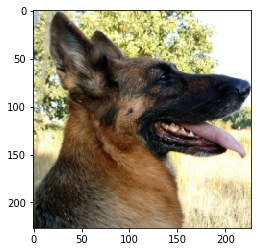

In [22]:
original_image = x_r[99]
original_image = scaler.inverse_transform(original_image)
img = np.reshape(original_image, (227,227,3))
img = Image.fromarray(img.astype('uint8'))
plt.imshow(img)

#### 2.1.2 First 60 principal components

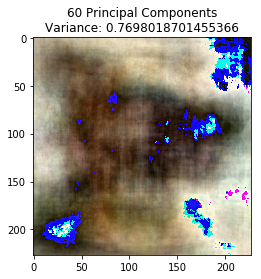

In [13]:
X_R_60, variance60 = getPCResults(X_t, copy.copy(my_pca), 0, 60)
img_60 = getReprojectedImage(X_R_60, scaler)
plotImage(img_60, variance60, 60)

As we can see, keeping 60 principal components results in an variance explanation equal to ~77%. The dog's shape is maintained, even with no much of details definition.

#### 2.1.3 First 6 principal components

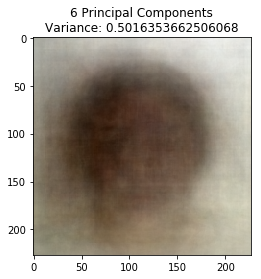

In [23]:
X_R_6, variance6 = getPCResults(X_t, copy.copy(my_pca), 0, 6)
img_6 = getReprojectedImage(X_R_6, scaler)
plotImage(img_6, variance6, 6)

#### 2.1.4 First 2 principal components

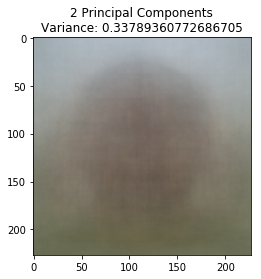

In [24]:
X_R_2, variance2 = getPCResults(X_t, copy.copy(my_pca), 0, 2)
img_2 = getReprojectedImage(X_R_2, scaler)
plotImage(img_2, variance2, 2)

Both this image and the previous one prove how keeping few principal components results in a non defined reprojection. 

#### 2.1.5 Last 6 principal components

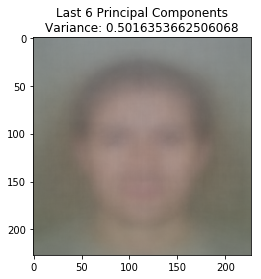

In [25]:
X_R_l6, variancel6 = getPCResults(X_t, copy.copy(my_pca), 1081, 1087)
img_l6 = getReprojectedImage(X_R_l6, scaler)
plotImage(img_l6, variancel6, 'Last 6')

Our dog seems to be become a person by using the last six principal components. 

### 2.2 Variance explained

As we can see, each reprojected image has a label indicating the variance related to it. This value gives an indication on how much information has been used to build the new images.
A question to do could be: how much variance is necessary to represented pretty well the compressed image?
Well, answering to this question isn't easy, because there isn't a true value. So, the only way to find a reasonable value of variance is plotting the variation of variance we can collect by increasing the number of components we use to build the model. I've done that below.

In [47]:
# Plots the variance spline function related to principal components
def plotSplineFunction(array):
    x_new = np.linspace(0, array.size, array.size)
    y = array
    plt.grid(True)
    plt.plot (x_new, y)
    plt.scatter (x_new, y)
    #plt.savefig(rootFolder + "variance_plot" + '.jpg')

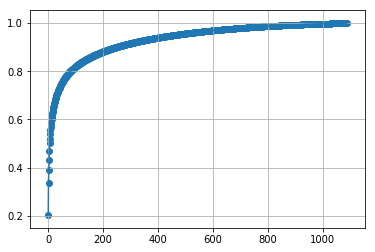

In [48]:
plotSplineFunction(my_pca.explained_variance_ratio_.cumsum())

This graph suggests us something on how to choose the right value of the variance to be satisfied by the compression.
In fact, we can see that just the first 200 principal components collect more than 80% of the informations. 
So if our goal is compressing the sample image by a factor of 0.8, have no sense keeping more than 200 principal components or more. 

### 2.3 Scatter plot visualization

In this section we see how the dataset is spreaded out after the PCA reduction, according by each class.
To do that, we have previously built an array of labels according to class each image belongs to.
Then we plot a scatter plot, that is a graph representing the position of each point according to the axis.
In our analysis we want to represent the points configuration after computing the eigenvectors, i.e. the new axis.

In [37]:
# Plots a scatter diagram to visualize principal components
def plotScatter(matrix, components_details, saving_name, index1, index2):
    dogIndex = numbers[0]-1
    guitarIndex = numbers[0]+numbers[1]-1
    houseIndex = numbers[0]+numbers[1]+numbers[2]-1
    personIndex = numbers[0]+numbers[1]+numbers[2]+numbers[3]-1

    colors=["red", "green", "dodgerblue", "yellow"]
    fig = plt.figure()
    a = fig.add_subplot(1, 1, 1)
    d = plt.scatter(matrix[0:dogIndex,index1], matrix[0:dogIndex,index2], marker='o', color=colors[0])
    g = plt.scatter(matrix[dogIndex+1:guitarIndex,index1], matrix[dogIndex+1:guitarIndex,index2], marker='o', color=colors[1])
    h = plt.scatter(matrix[guitarIndex+1:houseIndex,index1], matrix[guitarIndex+1:houseIndex,index2], marker='o', color=colors[2])
    p = plt.scatter(matrix[houseIndex+1:personIndex,index1], matrix[houseIndex+1:personIndex,index2], marker='o', color=colors[3])

    plt.legend((d,g,h,p),
               ('Dog', 'Guitar', 'House', 'Person'),
               loc='lower right',
               ncol=2,
               fontsize=8)
    plt.grid(True)
    a.set_title("Scatter plot of " + components_details + " principal components")
    #plt.savefig(rootFolder + saving_name + '.jpg')
    plt.show()

#### 2.3.1 First and second principal components

We have already computed the matrix containing the first two PC previously.
So, I just pass that matrix to the function to see the representation.

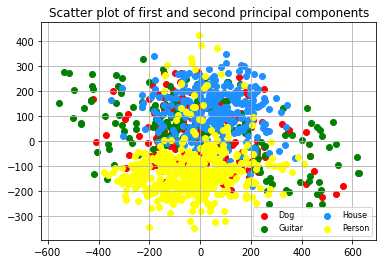

In [38]:
plotScatter(X_t, "first and second", "scatter_1_2", 0, 1)

#### 2.3.2 Third and fourth principal components

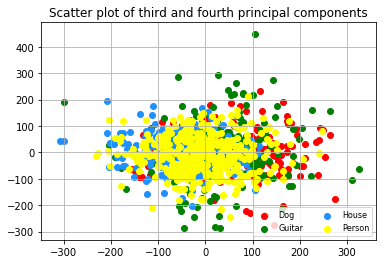

In [39]:
plotScatter(X_t, "third and fourth", "scatter_3_4", 2, 3)

#### 2.3.3 Tenth and eleventh principal components

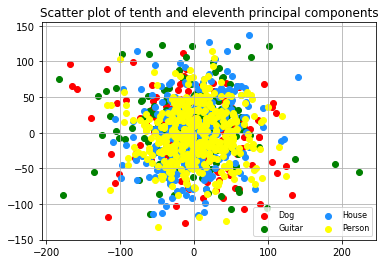

In [40]:
plotScatter(X_t, "tenth and eleventh", "scatter_10_11", 9, 10)